<a href="https://colab.research.google.com/github/Misheal-22/Loan-Approval-Prediction-Model/blob/main/Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
!pip install opendatasets

In [6]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: misheal22
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset


100%|██████████| 80.6k/80.6k [00:00<00:00, 86.7MB/s]

In [7]:
import pandas as pd
data=pd.read_csv("loan-approval-prediction-dataset/loan_approval_dataset.csv")
data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


QUICK EDA

In [8]:
print("\nMissing values per column:")
print(data.isna().sum().sort_values(ascending=False))


Missing values per column:
loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64


DETECTING TARGET AUTOMATICALLY

In [9]:
possible_targets = ['Loan_Status', 'Loan_Status ', 'Loan_Status', 'approved', 'Approved', 'status', 'Loan_Status']
target = None
for t in ['Loan_Status', 'Loan_Status ', 'Loan_Status', 'Loan_Status', 'Approved', 'approved', 'Status', 'status', 'Outcome', 'Loan_Status']:
    if t in data.columns:
        target = t
        break

if target is None:
    target = data.columns[-1]
    print(f"\nWarning: couldn't detect common target names. Using last column as target: '{target}'")

print("\nUsing target:", target)
print(data[target].value_counts(dropna=False))




Using target:  loan_status
 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


MAPPING TARGET TO BINARY (IF NOT NUMERIC)

In [10]:
if data[target].dtype == 'object' or not np.issubdtype(data[target].dtype, np.number):
    print("\nMapping target to binary (Approved -> 1, others -> 0) heuristically.")

    mapping = {}
    vals = data[target].dropna().unique().tolist()

    for v in vals:
        s = str(v).strip().lower()
        if s in ['y', 'yes', 'approved', 'approve', '1', 'true', 'accepted']:
            mapping[v] = 1
        else:
            mapping[v] = 0
    data[target] = data[target].map(mapping).astype(int)


Mapping target to binary (Approved -> 1, others -> 0) heuristically.


SPLIT FEATURES AND TARGET

In [11]:
X = data.drop(columns=[target])
y = data[target].astype(int)

IDENTIFY NUMERIC AND CATEGORICAL COLUMNS

In [12]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']
Categorical columns: [' education', ' self_employed']


CORECE

In [13]:
for c in cat_cols[:]:
    try:
        coerced = pd.to_numeric(X[c].dropna())
        # if a substantial portion can be coerced to numeric, convert column
        if len(coerced) / max(1, len(X[c].dropna())) > 0.8:
            X[c] = pd.to_numeric(X[c], errors='coerce')
            numeric_cols.append(c)
            cat_cols.remove(c)
    except Exception:
        pass

print("\nAfter coercion Numeric:", numeric_cols)
print("After coercion Categorical:", cat_cols)


After coercion Numeric: ['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']
After coercion Categorical: [' education', ' self_employed']


PREPROCESSING PIPELINES

In [15]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical: impute missing with 'MISSING', then one-hot encode (drop='if_binary' to reduce col count)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'  # drop any other columns
)

SPLIT DATA


Train class distribution:
  loan_status
1    0.622255
0    0.377745
Name: proportion, dtype: float64
Test class distribution:
  loan_status
1    0.62178
0    0.37822
Name: proportion, dtype: float64

Training baseline LogisticRegression (class_weight='balanced') ...

=== Evaluation: LogisticRegression (class_weight) ===
              precision    recall  f1-score   support

           0     0.8779    0.9350    0.9055       323
           1     0.9588    0.9209    0.9395       531

    accuracy                         0.9262       854
   macro avg     0.9184    0.9279    0.9225       854
weighted avg     0.9282    0.9262    0.9266       854



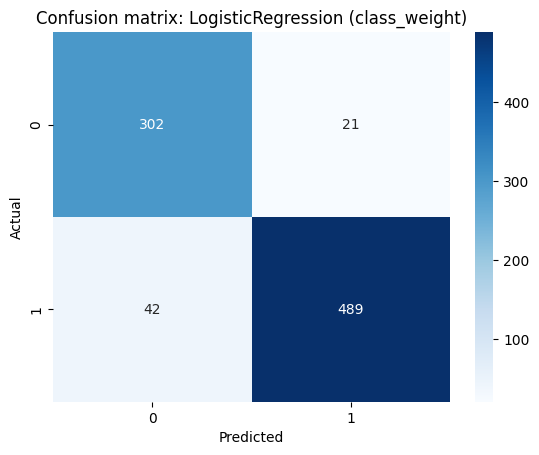

ROC AUC: 0.9731

Training baseline DecisionTree (class_weight='balanced') ...

=== Evaluation: DecisionTree (class_weight) ===
              precision    recall  f1-score   support

           0     0.9842    0.9628    0.9734       323
           1     0.9777    0.9906    0.9841       531

    accuracy                         0.9801       854
   macro avg     0.9809    0.9767    0.9787       854
weighted avg     0.9801    0.9801    0.9800       854



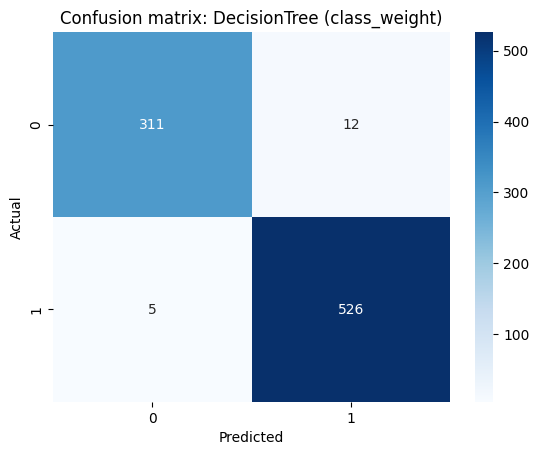

ROC AUC: 0.9767

Training with SMOTE + LogisticRegression ...

=== Evaluation: SMOTE + LogisticRegression ===
              precision    recall  f1-score   support

           0     0.8801    0.9319    0.9053       323
           1     0.9570    0.9228    0.9396       531

    accuracy                         0.9262       854
   macro avg     0.9186    0.9273    0.9224       854
weighted avg     0.9279    0.9262    0.9266       854



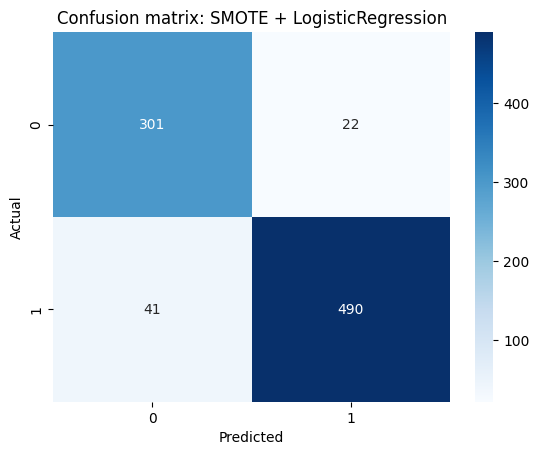

ROC AUC: 0.9731

Training with SMOTE + DecisionTree ...

=== Evaluation: SMOTE + DecisionTree ===
              precision    recall  f1-score   support

           0     0.9689    0.9659    0.9674       323
           1     0.9793    0.9812    0.9802       531

    accuracy                         0.9754       854
   macro avg     0.9741    0.9736    0.9738       854
weighted avg     0.9754    0.9754    0.9754       854



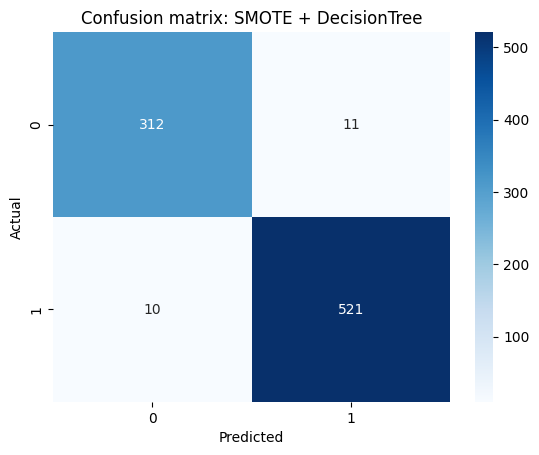

ROC AUC: 0.9736

Grid search example for DecisionTree (focusing on F1)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 5}

=== Evaluation: Tuned DecisionTree (SMOTE, F1-focused) ===
              precision    recall  f1-score   support

           0     0.9844    0.9783    0.9814       323
           1     0.9869    0.9906    0.9887       531

    accuracy                         0.9859       854
   macro avg     0.9856    0.9845    0.9850       854
weighted avg     0.9859    0.9859    0.9859       854



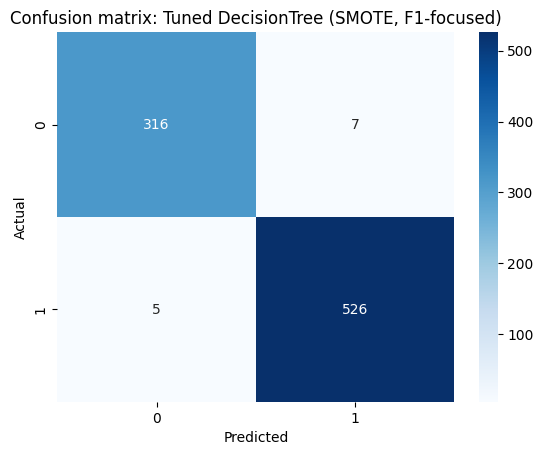

ROC AUC: 0.9894

Top feature importances (DecisionTree):
 cibil_score                 0.785554
 loan_term                   0.116440
 loan_amount                 0.035652
 income_annum                0.026981
 residential_assets_value    0.017879
 commercial_assets_value     0.008186
 luxury_assets_value         0.003689
 bank_asset_value            0.002386
 no_of_dependents            0.001545
 self_employed_ No           0.001197
 education_ Not Graduate     0.000492
loan_id                      0.000000
 education_ Graduate         0.000000
 self_employed_ Yes          0.000000
dtype: float64


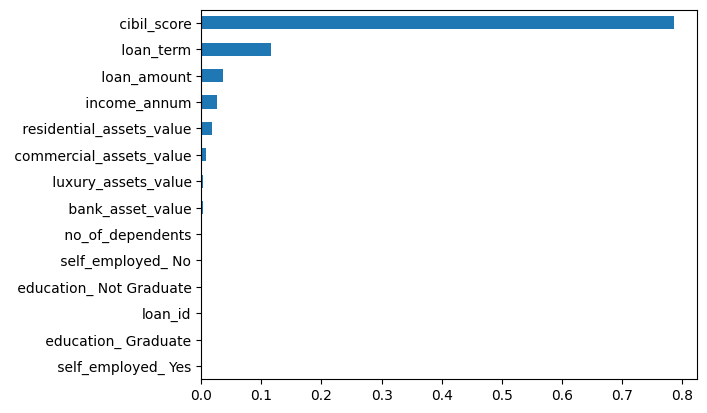


Top logistic coefficients (absolute):
 cibil_score                 4.387133
 income_annum               -1.602542
 loan_amount                 1.383489
 loan_term                  -0.813662
 education_ Graduate         0.404373
 self_employed_ Yes          0.356281
 self_employed_ No           0.348364
 education_ Not Graduate     0.300272
 bank_asset_value            0.144981
 luxury_assets_value         0.141352
 commercial_assets_value     0.066284
loan_id                      0.062549
 residential_assets_value    0.055299
 no_of_dependents           -0.044275
dtype: float64

Model comparison (by F1):
                model  precision    recall        f1   roc_auc
4  DT (Tuned + SMOTE)   0.986867  0.990584  0.988722  0.989362
1   DT (class_weight)   0.977695  0.990584  0.984097  0.976716
3          DT (SMOTE)   0.979323  0.981168  0.980245  0.973556
2          LR (SMOTE)   0.957031  0.922787  0.939597  0.973075
0   LR (class_weight)   0.958824  0.920904  0.939481  0.973122

Saved mo

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

# ---------------------------
# Option A: Baseline with class_weight
# ---------------------------

pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

pipe_dt = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            y_proba = None
    print(f"\n=== Evaluation: {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC: {auc:.4f}")

# Fit baselines
print("\nTraining baseline LogisticRegression (class_weight='balanced') ...")
pipe_lr.fit(X_train, y_train)
evaluate_model(pipe_lr, X_test, y_test, "LogisticRegression (class_weight)")

print("\nTraining baseline DecisionTree (class_weight='balanced') ...")
pipe_dt.fit(X_train, y_train)
evaluate_model(pipe_dt, X_test, y_test, "DecisionTree (class_weight)")

# ---------------------------
# Option B: SMOTE then modeling (recommended when minority is small)
# ---------------------------

# Build an imblearn pipeline: preprocessing (fit on entire training set inside pipeline),
# then SMOTE (only on training), then classifier
smote = SMOTE(random_state=42)

imb_pipe_lr = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

imb_pipe_dt = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', DecisionTreeClassifier(random_state=42))
])

print("\nTraining with SMOTE + LogisticRegression ...")
imb_pipe_lr.fit(X_train, y_train)
evaluate_model(imb_pipe_lr, X_test, y_test, "SMOTE + LogisticRegression")

print("\nTraining with SMOTE + DecisionTree ...")
imb_pipe_dt.fit(X_train, y_train)
evaluate_model(imb_pipe_dt, X_test, y_test, "SMOTE + DecisionTree")

# ---------------------------
# Hyperparameter tuning (GridSearchCV) optimizing F1 or Recall
# ---------------------------
print("\nGrid search example for DecisionTree (focusing on F1)...")
param_grid_dt = {
    'clf__max_depth': [3, 5, 7, None],
    'clf__min_samples_leaf': [1, 5, 10],
    'clf__criterion': ['gini', 'entropy']
}

# Wrap pipeline with SMOTE (imb pipeline) for grid search
gs_pipe_dt = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(gs_pipe_dt, param_grid_dt, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_dt = gs.best_estimator_
evaluate_model(best_dt, X_test, y_test, "Tuned DecisionTree (SMOTE, F1-focused)")

# Get feature importances (requires mapping OHE feature names)
def get_feature_names(column_transformer):
    # adapted helper to extract feature names
    feature_names = []
    if hasattr(column_transformer, 'transformers_'):
        for name, trans, cols in column_transformer.transformers_:
            if name == 'num':
                feature_names.extend(cols)
            elif name == 'cat':
                # onehot encoder
                ohe = trans.named_steps['onehot']
                imputer = trans.named_steps['imputer']
                cat_cols_local = cols
                if hasattr(ohe, 'get_feature_names_out'):
                    names = ohe.get_feature_names_out(cat_cols_local).tolist()
                else:
                    names = []
                    for i, c in enumerate(cat_cols_local):
                        # fallback
                        names.append(c)
                feature_names.extend(names)
    return feature_names

try:
    feat_names = get_feature_names(preprocessor)
    if hasattr(best_dt.named_steps['clf'], 'feature_importances_'):
        importances = best_dt.named_steps['clf'].feature_importances_
        feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)
        print("\nTop feature importances (DecisionTree):")
        print(feat_imp)
        feat_imp.plot(kind='barh')
        plt.gca().invert_yaxis()
        plt.show()
except Exception as e:
    print("Could not compute feature names/importances:", e)

# For logistic regression coefficients (SMOTE + LR)
try:
    if isinstance(imb_pipe_lr.named_steps['clf'], LogisticRegression):
        lr = imb_pipe_lr.named_steps['clf']
        coef = lr.coef_[0]
        feat_names = get_feature_names(preprocessor)
        coef_ser = pd.Series(coef, index=feat_names).sort_values(key=abs, ascending=False).head(20)
        print("\nTop logistic coefficients (absolute):")
        print(coef_ser)
except Exception as e:
    print("Couldn't extract logistic coefficients:", e)

# ---------------------------
# Additional outputs: summary metrics
# ---------------------------
def summary_metrics(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = None
    if hasattr(model, "predict_proba"):
        try:
            auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        except:
            auc = None
    return {'model': label, 'precision': p, 'recall': r, 'f1': f1, 'roc_auc': auc}

models = [
    (pipe_lr, "LR (class_weight)"),
    (pipe_dt, "DT (class_weight)"),
    (imb_pipe_lr, "LR (SMOTE)"),
    (imb_pipe_dt, "DT (SMOTE)"),
    (best_dt, "DT (Tuned + SMOTE)")
]

metrics = []
for m, name in models:
    try:
        metrics.append(summary_metrics(m, X_test, y_test, name))
    except Exception as e:
        print("Error summarizing", name, e)

metrics_df = pd.DataFrame(metrics).sort_values(by='f1', ascending=False)
print("\nModel comparison (by F1):")
print(metrics_df)

# Save results
metrics_df.to_csv("model_comparison_metrics.csv", index=False)
print("\nSaved model_comparison_metrics.csv")